In [ ]:
import os
import random
import itertools
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
def process_dataset(df, path, label_list):
    img_list = glob(path + '/*.jpg')
    for img in img_list:
      file_name = os.path.splitext(img)[0].split("/")[-1]
      for i, label in enumerate(label_list):
            if file_name.startswith(label):
                new_data = pd.DataFrame({"path": [img], "label": [label], "class_id": [i]})
                df = pd.concat([df, new_data], ignore_index=True)
                break
    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)
    return df

In [ ]:
train_df = pd.DataFrame({"path": [], "label": [], "class_id": []})
train_path = '/data/Training'
label_list = ['notsmoking', 'smoking']
train_df = process_dataset(train_df, train_path, label_list)

In [ ]:
train_df.head()

,path,label,class_id


In [ ]:
val_df = pd.DataFrame({"path": [], "label": [], "class_id": []})
val_path = '/data/Validation'
val_df = process_dataset(val_df, val_path, label_list)

In [ ]:
val_df.head()

,path,label,class_id


In [ ]:
test_df = pd.DataFrame({"path": [], "label": [], "class_id": []})
test_path = '/data/Testing'
test_df = process_dataset(test_df, test_path, label_list)

In [ ]:
test_df.head()

,path,label,class_id


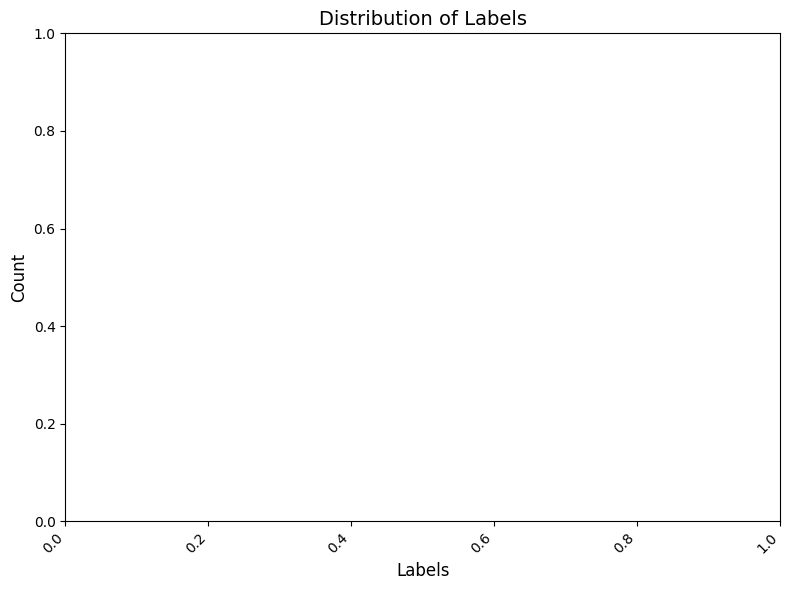

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=train_df["label"], palette="Set2")
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Labels", fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
show_imgs = 15

idx = np.random.randint(0, len(train_df), size=show_imgs)

fig, axes = plt.subplots(show_imgs // 5, 5, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'], fontsize=10)
    ax.set_axis_off()

plt.suptitle("Random Sample of Images", fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

ValueError: high <= 0

In [ ]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

ValueError: high <= 0

In [ ]:
img_size = (224, 224)
batch_size = 16
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

In [ ]:
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='path', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(val_df, x_col='path', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='path', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize=(14, 12))
for i in range(12):
    image = images[i] / 255

    plt.subplot(3, 4, i + 1)
    plt.imshow(image)

    index = np.argmax(labels[i])
    class_name = classes[index]

    title_color = 'darkblue' if class_name == 'notsmoking' else 'darkred'
    plt.title(f"Person - {class_name}", color=title_color, fontsize=10)
    plt.axis('off')

plt.tight_layout(pad=0.5)

plt.suptitle("Sample Images of Smokers and Non-Smokers with Labels", y=1.02, fontsize=16, color='violet', fontweight='bold')

plt.gcf().set_facecolor('#f0f0f0')
plt.grid(False)

plt.show()

In [ ]:

input_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet', pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Model Summary:")
model.summary()

In [ ]:
history = model.fit(x= train_gen , epochs = 30, verbose = 1, validation_data= valid_gen,validation_steps = None , shuffle = False)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

ax1 = axes[0]
ax1.plot(epochs, loss, label='Training Loss', marker='o', color='blue', linewidth=2)
ax1.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange', linewidth=2)
ax1.fill_between(epochs, loss, val_loss, color='blue', alpha=0.1)
ax1.fill_between(epochs, val_loss, color='orange', alpha=0.1)
ax1.set_title('Loss', fontsize=16)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2 = axes[1]
ax2.plot(epochs, accuracy, label='Training Accuracy', marker='o', color='green', linewidth=2)
ax2.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='red', linewidth=2)
ax2.fill_between(epochs, accuracy, val_accuracy, color='green', alpha=0.1)
ax2.fill_between(epochs, val_accuracy, color='red', alpha=0.1)
ax2.set_title('Accuracy', fontsize=16)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def display_classification_report(y_true, y_pred, class_names):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=-1)
class_names = list(test_gen.class_indices.keys())

display_classification_report(y_true, y_pred, class_names)

plot_confusion_matrix(y_true, y_pred, class_names)